#Project ML1 predict_students_dropout_and_academic_success
---






##1-Loading Important Libraries:



In [1]:
!pip install ucimlrepo
!pip install dash
!pip install dash-bootstrap-components
!pip install dash-table


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 221.2/221.2 kB 2.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency
from sklearn.feature_selection import f_classif
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_score, recall_score, accuracy_score,f1_score, classification_report




## **Making important functions`**




1-Data Collection<br>
2 Data Cleaning<br>
3 Data Transformation<br>
4 Exploratory Data Analysis<br>
5 Detecting Outliers and Anomalies<br>
6 Feature Engineering<br>
7 Dimensionality Reduction<br>
8 Manual Data Splitting and Cross Validation<br>
9 Model Selection<br>
10 Model Training<br>
11-Model Evaluation<br>
12 Master function<br>

###**1- Function for Data Collection:**
Thisfunction will collect the data by giving the ID of data from the user interface.




In [3]:
def import_dataset(): #This function will import the dataset from Machine Learning Repository by using its id

    data_sets = {
        697: "predict_students_dropout_and_academic_success",
        468: "online_shoppers_purchasing_intention_dataset",
        45: "Heart Disease",
        544: "estimation_of_obesity_levels",
        144: "credit_approval"
    }

    print("Kindly provide the id of the ucirepo:")
    print("predict_students_dropout_and_academic_success = 697")
    print("online_shoppers_purchasing_intention_dataset = 468")
    print("Heart Disease=45")
    print('estimation_of_obesity_levels=544')
    print('credit_approval_dataset=144')

    data_id = int(input("Kindly input id of dataset:"))

    # Check if data_id exists in the dictionary
    if data_id not in data_sets:
        print("\033[1;30;47m" + "Invalid dataset ID."+ "\033[m")
        return
    #getting name of data set
    data_set_name=data_sets[data_id]
    # fetch dataset
    data_set = fetch_ucirepo(id=data_id)
    meta_data= data_set.metadata

    # data (as pandas dataframes)
    X = data_set.data.features
    y = data_set.data.targets

    data = pd.concat([X, y], axis=1)
    data=pd.DataFrame(data)
    rows,columns=data.shape
    print("\033[1;30;47m" + "You have selected to work with " + str(data_set_name) +" which has number of columns="+ str (columns)+ " and number of rows="+str(rows)+"\033[m")
    return data


### **2- Function for Data Cleaning:**

This function will deal with null values and duplicates by asking the user way to handle it.

In [5]:
def dealing_with_null(df): #This function will clean the dataset.


    print("Observe above chart and decide What do you want to do with your null values")
    print("press 1 if you want to drop rows with null values")
    print('press 2 if you want to fill null values with mean')
    print('press any key if there are no null values in data')
    decision=input("Kindly mention your choice to deal with null values:")
    if decision=='1':

       #Handling mising values
       print("All the rows with null values have been dropped")
       df.dropna(inplace=True)
       return(df)
    elif decision=='2':
       print("All the places with null values have been filled with mean of coulmns ")
       means = df.mean()  # Calculate the mean of each column
       df.fillna(value=means, inplace=True)  # Fill missing values with mean values
       return(df)
    elif decision!='1' or '2':
       return(df)






In [6]:
def dealing_with_duplicates(df): #This function will clean the dataset.
    print("Number of duplicate rows in your data set:",df.duplicated().sum())
    print("All the duplicate rows have been deleted from data set")

    df.drop_duplicates(inplace=True)
    return(df)







### **3-Tranformations:**
This function will perform the normalization on data.If categorical features are strings then function will convert it into numeric form and displays the dictionary of conversion.





In [7]:

def z_score_normalize(df):# Apply z-score normalization to specified numerical features but use with precaution if required
    Numeric_features=df.select_dtypes(include='float64').columns
    for feature in Numeric_features:
        df[feature] = zscore(df[feature])
    return df




In [8]:


def plot_unique_values(df):
    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            continue  # Skip numerical columns
        else:
            plt.figure(figsize=(8, 6))
            df[col].value_counts().plot(kind='bar', color='skyblue')
            plt.title(f'Unique Values of {col}')
            plt.xlabel('Values')
            plt.ylabel('Count')
            plt.show()





def encode_numerical_features(df):
    encoded_df = df.copy()
    label_encoders = {}  # Dictionary to store label encoders for each categorical feature

    categorical_features = df.select_dtypes(include='object').columns  # Extract column names

    for feature in categorical_features:
        if not pd.api.types.is_numeric_dtype(df[feature]):
            # Perform label encoding for categorical variables
            label_encoder = LabelEncoder()
            encoded_df[feature] = label_encoder.fit_transform(encoded_df[feature])

            # Store variable name along with category labels
            label_encoders[feature] = {category: label for label, category in enumerate(label_encoder.classes_)}

    # Print the label encoders
    for feature, encoding_mapping in label_encoders.items():
        print(f"Encoding mapping for {feature}:")
        for category, label in encoding_mapping.items():
            print(f"  {category} -> {label}")

    return encoded_df




### **6-Feature Selection:**
Here we are using ChiSquare and Fstatistics test to select features manually, we will also drop features with high multi collinearity.

In [9]:
def chisquare(X_train,y_train):
    X_train_cat = X_train.select_dtypes(include = 'int64'or 'object').copy()
    # define an empty dictionary to store chi-squared test results
    chi2_check = {}

    # loop over each column in the training set to calculate chi-statistic with the target variable
    for column in X_train_cat:
         chi, p, dof, ex = chi2_contingency(pd.crosstab(y_train, X_train_cat[column]))
         chi2_check.setdefault('Feature',[]).append(column)
         chi2_check.setdefault('p-value',[]).append(round(p, 10))

    # convert the dictionary to a DF
    chi2_result = pd.DataFrame(data = chi2_check)
    chi2_result.sort_values(by = ['p-value'], ascending = True, ignore_index = True, inplace = True)
    return chi2_result


In [10]:
def FStatistics(X_train,y_train):
   X_train_num = X_train.select_dtypes(include = 'float64').copy()
   # Calculate F Statistic and corresponding p values
   F_statistic, p_values = f_classif(X_train_num, y_train)
   # convert to a DF
   ANOVA_F_table = pd.DataFrame(data = {'Numerical_Feature': X_train_num.columns.values, 'F-Score': F_statistic, 'p values': p_values.round(decimals=10)})
   ANOVA_F_table.sort_values(by = ['F-Score'], ascending = False, ignore_index = True, inplace = True)
   return ANOVA_F_table

### **7-Dimensionality Reduction:**

### **8-Manual Data Splitting and Cross Validation:**

This function will manually split the data into test and train and you can give splitting size.Here we are using KNN to find best value of k to give to the algo.

In [11]:
def split_dataset(df,n=-1):# This function is assuming last coulmn is your label if its not then change value of n, test size is the split size of test data 0.2 is for 20%
    X = df.drop(df.columns[n], axis=1)
    y = df.iloc[:,n]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2 , random_state = 42, stratify = y)
    X_train, X_test = X_train.copy(), X_test.copy()
    return X_train, X_test, y_train, y_test

#Using cross validation for finding best value of k
def cross_validation(df,n):
    X = df.drop(df.columns[-1], axis=1)
    y = df.iloc[:,-1]
    k_values = [i for i in range (1,n)]
    scores = []

    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        score = cross_val_score(knn, X, y, cv=5)
        scores.append(np.mean(score))

    sns.lineplot(x = k_values, y = scores, marker = 'o')
    plt.xlabel("K Values")
    plt.ylabel("Accuracy Score")
    plt.show()
    return


### **9-Model Selection:**

### **10-Model Training:**

In [12]:
def knn(X_train,y_train,X_test,k):
  # Create a KNN classifier with k=3
   knn = KNeighborsClassifier(n_neighbors=3)

   # Train the classifier on the training data
   knn.fit(X_train, y_train)

   # Make predictions on the testing data
   y_pred = knn.predict(X_test)

   return y_pred




##**MasterFunction:**
To understand the terms in a better way we are running master function in apiece wise manner.






## **<font color="green">Step no 1:Observation of null values and data types</font>**


In [13]:
data=import_dataset()
types=data.dtypes
null_counts = data.isnull().sum()
data_details=pd.concat([null_counts,types],axis=1)
data_details.columns=['null_counts','data_type']
print(data_details)



Kindly provide the id of the ucirepo:
predict_students_dropout_and_academic_success = 697
online_shoppers_purchasing_intention_dataset = 468
Heart Disease=45
estimation_of_obesity_levels=544
credit_approval_dataset=144
Kindly input id of dataset:544
You have selected to work with estimation_of_obesity_levels which has number of columns=17 and number of rows=2111
                                null_counts data_type
Gender                                    0    object
Age                                       0   float64
Height                                    0   float64
Weight                                    0   float64
family_history_with_overweight            0    object
FAVC                                      0    object
FCVC                                      0   float64
NCP                                       0   float64
CAEC                                      0    object
SMOKE                                     0    object
CH2O                                     

## **<font color="green">Step no 2:In this step we will do EDA and deal with null values and duplicates.</font>**



In [14]:
data1=dealing_with_null(data)
data2=dealing_with_duplicates(data1)
data3=encode_numerical_features(data2)


Observe above chart and decide What do you want to do with your null values
press 1 if you want to drop rows with null values
press 2 if you want to fill null values with mean
press any key if there are no null values in data
Kindly mention your choice to deal with null values:1
All the rows with null values have been dropped
Number of duplicate rows in your data set: 24
All the duplicate rows have been deleted from data set
Encoding mapping for Gender:
  Female -> 0
  Male -> 1
Encoding mapping for family_history_with_overweight:
  no -> 0
  yes -> 1
Encoding mapping for FAVC:
  no -> 0
  yes -> 1
Encoding mapping for CAEC:
  Always -> 0
  Frequently -> 1
  Sometimes -> 2
  no -> 3
Encoding mapping for SMOKE:
  no -> 0
  yes -> 1
Encoding mapping for SCC:
  no -> 0
  yes -> 1
Encoding mapping for CALC:
  Always -> 0
  Frequently -> 1
  Sometimes -> 2
  no -> 3
Encoding mapping for MTRANS:
  Automobile -> 0
  Bike -> 1
  Motorbike -> 2
  Public_Transportation -> 3
  Walking -> 4
Encodi

## **<font color="green">Step no 3:Possible Options of feature Engineering, Cross validation and Classification report..</font>**



In [15]:

# Split dataset into train and test
X_train, X_test, y_train, y_test = split_dataset(data3, n=-1)

# Feature SX_trainelection
print("ChiSquare Test Results")
chi2_result = chisquare(X_train, y_train)
print(chi2_result)

#print("FStatistic test result")
#fstat_result = FStatistics(X_train, y_train)
#print(fstat_result)



ChiSquare Test Results
                          Feature   p-value
0                          Gender  0.000000
1  family_history_with_overweight  0.000000
2                            FAVC  0.000000
3                            CAEC  0.000000
4                             SCC  0.000000
5                            CALC  0.000000
6                          MTRANS  0.000000
7                           SMOKE  0.000401


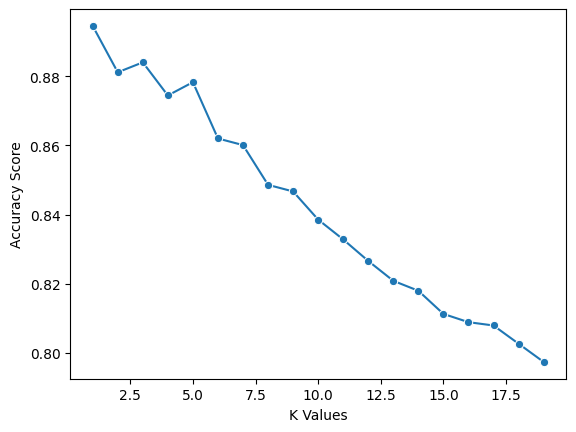

In [16]:
# Model Training and Evaluation
# Finding best value of k
cross_validation(data3, 20)


# Train and evaluate KNN model
y_pred = knn(X_train, y_train, X_test, 1)


## **Interpretation of results:**
This was a multi class classification problem with 6 class labels and the KNN algorithm is working well on this without feature selection.By observation of graph we are taking k=1.

###**4-Exploratory Data Analysis:**
This function will show the five numer summary of numeric features.<br>
It displays histogram of each numerical variable.<br>
It displays box plot for each numerical feature.<br>
It displays correlation matrix between numerical features.<br>
### **5-Detecting Ouliers and Anomalies:**
Outliers have already been detected by boxplots but right now we are leaving their handling case.
### **11-Model Evaluation:**
Model evaluation function is different according to binary classification and multi class classification.


In [17]:
import dash
import dash_html_components as html
import dash_core_components as dcc
import plotly.express as px
import plotly.graph_objects as go
import dash_table
import pandas as pd
import numpy as np
from dash.dependencies import Input, Output
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score

# Function for EDA Dashboard
def eda(data2):
    # Summary statistics
    summary_stats = data2.describe()

    # Histograms for each numerical variable
    histograms = []
    for column in data2.select_dtypes(include=np.number):
        histogram = px.histogram(data2, x=column, title=f'Histogram of {column}', color_discrete_sequence=['maroon'], width=400, height=300)
        histograms.append(dcc.Graph(figure=histogram))

    # Box plots for each numerical variable
    box_plots = []
    for column in data2.select_dtypes(include=np.number):
        box_plot = px.box(data2, y=column, title=f'Boxplot of {column}', color_discrete_sequence=['maroon'], width=400, height=300)
        box_plots.append(dcc.Graph(figure=box_plot))

    # Correlation matrix
    corr_matrix = go.Figure(data=go.Heatmap(z=data2.corr(), x=data2.columns, y=data2.columns, colorscale='RdBu'))
    corr_matrix.update_layout(title='Correlation Matrix', plot_bgcolor='#f8f8f8', width=800, height=600)

    return html.Div(style={'backgroundColor': '#FFFFFF', 'color': 'maroon', 'padding': '20px'}, children=[
        html.H1("Exploratory Data Analysis", style={'textAlign': 'center'}),
        html.Div([
            html.Div([
                html.H2("Summary Statistics", style={'color': 'maroon', 'textAlign': 'center'}),
                dcc.Markdown(summary_stats.to_markdown())
            ], style={'margin': '10px', 'textAlign': 'center'}),
            html.Div([
                html.H2("Histograms", style={'color': 'maroon', 'textAlign': 'center'}),
                html.Div(histograms, style={'display': 'flex', 'flexWrap': 'wrap', 'justifyContent': 'center', 'alignItems': 'center'})
            ], style={'margin': '10px', 'textAlign': 'center'}),
            html.Div([
                html.H2("Box Plots", style={'color': 'maroon', 'textAlign': 'center'}),
                html.Div(box_plots, style={'display': 'flex', 'flexWrap': 'wrap', 'justifyContent': 'center', 'alignItems': 'center'})
            ], style={'margin': '10px', 'textAlign': 'center'})
        ]),
        html.Div([
            html.H2("Correlation Matrix", style={'color': 'maroon', 'textAlign': 'center'}),
            dcc.Graph(figure=corr_matrix, style={'backgroundColor': '#f8f8f8'})
        ], style={'margin': '10px', 'textAlign': 'center'})
    ])


# Function for Classification Evaluation Dashboard
def evaluate_classification(y_test, y_pred):
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Compute precision, recall, and F1 score
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Compute accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Generate classification report
    report = classification_report(y_test, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose().reset_index()

    # Create the dashboard
    return html.Div(style={'backgroundColor': '#FFFFFF', 'color': 'maroon', 'padding': '20px'}, children=[
        html.Div(
            children='Classification Evaluation',
            style={'textAlign': 'center', 'fontWeight': 'bold'}
        ),

        html.Div(children=f'Accuracy: {accuracy:.2f}', style={'textAlign': 'center'}),
        html.Div(children=f'Precision: {precision:.2f}', style={'textAlign': 'center'}),
        html.Div(children=f'Recall: {recall:.2f}', style={'textAlign': 'center'}),
        html.Div(children=f'F1 Score: {f1:.2f}', style={'textAlign': 'center'}),

        html.Div(children='Confusion Matrix:', style={'textAlign': 'center', 'fontWeight': 'bold', 'marginBottom': '10px'}),

        dash_table.DataTable(
            id='confusion-matrix-table',
            columns=[{'name': '', 'id': 'index'}] + [{'name': col, 'id': col} for col in ['Predicted True', 'Predicted False']],
            data=[{'index': 'Actual True', 'Predicted True': cm[0][0], 'Predicted False': cm[0][1]},
                  {'index': 'Actual False', 'Predicted True': cm[1][0], 'Predicted False': cm[1][1]}],
            style_header={'backgroundColor': 'maroon', 'color': 'white', 'fontWeight': 'bold'},
            style_cell={'textAlign': 'center'}
        ),

        html.Div(children='Classification Report:', style={'textAlign': 'center', 'fontWeight': 'bold', 'marginTop': '10px'}),

        dcc.Graph(
            id='classification-report',
            figure={
                'data': [
                    go.Table(
                        header=dict(values=report_df.columns),
                        cells=dict(values=[report_df[col] for col in report_df.columns])
                    )
                ],
                'layout': {
                    'margin': {'l': 0, 'r': 0, 't': 0, 'b': 0}
                }
            }
        )
    ])

# Example usage:
# Combine both functionalities into a single dashboard
# Assuming df, y_test, and y_pred are already defined
app_combined = dash.Dash(__name__)

# Define app layout
app_combined.layout = html.Div(style={'backgroundColor': '#FFFFFF', 'padding': '20px'}, children=[
    html.Div(eda(data2), style={'width': '100%', 'textAlign': 'center'}),
    html.Div(evaluate_classification(y_test, y_pred), style={'width': '100%', 'textAlign': 'center'})
])

# Run the app
if __name__ == '__main__':
    app_combined.run_server(debug=True)


<ipython-input-17-fe140b1fc5d9>:2: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
<ipython-input-17-fe140b1fc5d9>:3: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
<ipython-input-17-fe140b1fc5d9>:6: UserWarning: 
The dash_table package is deprecated. Please replace
`import dash_table` with `from dash import dash_table`

Also, if you're using any of the table format helpers (e.g. Group), replace 
`from dash_table.Format import Group` with 
`from dash.dash_table.Format import Group`
  import dash_table
<ipython-input-17-fe140b1fc5d9>:30: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_onl

<IPython.core.display.Javascript object>

# **<font color="red">EDA Summary Report</font>**



##**Interpretation of Box Plot**


| Feature                        | Box plot   |
|--------------------------------|------------|
|Age         |Many Outliers|
|Height                 |No outliers|
|weight|No Outliers|                        
|FCVC|No Outliers|                       
| NCP             | No Outliers|                       
|CH2O                  | No outliers|                         
|FAF                            | No outliers|
|TUE|No Outliers|                        


##**Interpretation of multicollinearity**
 There is a high multicollinearity between NCP, Gender and FCVC

# **<font color="red">EVALUATION REPORT**

## **Interpretation of results:**
This was a multi class classification problem with 6 class labels and the KNN algorithm is working well on this without feature selection.By observation of graph we are taking k=1.